In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, Activation, LSTM, Convolution1D, MaxPooling1D, Flatten
from keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
## Data preparation

In [3]:
data= pd.read_csv('^DJI.csv')
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4279,2017-01-05,19924.560547,19948.599609,19811.119141,19899.289063,19899.289063,269920000
4280,2017-01-06,19906.960938,19999.630859,19834.080078,19963.800781,19963.800781,277700000
4281,2017-01-09,19931.410156,19943.779297,19887.380859,19887.380859,19887.380859,287060000
4282,2017-01-10,19876.349609,19957.119141,19836.029297,19855.529297,19855.529297,299410000
4283,2017-01-11,19887.380859,19973.419922,19833.160156,19954.279297,19954.279297,336150000


In [4]:
data= data.dropna(axis=0)
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4279,2017-01-05,19924.560547,19948.599609,19811.119141,19899.289063,19899.289063,269920000
4280,2017-01-06,19906.960938,19999.630859,19834.080078,19963.800781,19963.800781,277700000
4281,2017-01-09,19931.410156,19943.779297,19887.380859,19887.380859,19887.380859,287060000
4282,2017-01-10,19876.349609,19957.119141,19836.029297,19855.529297,19855.529297,299410000
4283,2017-01-11,19887.380859,19973.419922,19833.160156,19954.279297,19954.279297,336150000


In [5]:
data= data.values[:, 1:5]
print (data.shape)

(4284, 4)


In [6]:
print (data[:6, :])

[[11501.849609 11522.009766 11305.69043 11357.509766]
 [11349.75 11350.05957 10986.450195 10997.929688]
 [10989.370117 11215.099609 10938.669922 11122.650391]
 [11113.370117 11313.450195 11098.450195 11253.259766]
 [11247.05957 11528.139648 11239.919922 11522.55957]
 [11532.480469 11638.280273 11532.480469 11572.200195]]


In [7]:
y= data[1:, 3]
print (y.shape)
X= data[:4283,:]
print (X.shape)

(4283,)
(4283, 4)


In [8]:
# y= (y- min(y))/(max(y)- min(y))
print (y[4270:])
print (y[:7])

[19918.880859 19933.810547 19945.039063 19833.679688 19819.779297
 19762.599609 19881.759766 19942.160156 19899.289063 19963.800781
 19887.380859 19855.529297 19954.279297]
[10997.929688 11122.650391 11253.259766 11522.55957 11572.200195
 11511.080078 11551.099609]


In [9]:
# X= (X- np.min(X,axis=0))/(np.max(X, axis=0)-np.min(X,axis=0))
print (X.shape)
print (X[:3, :])

(4283, 4)
[[11501.849609 11522.009766 11305.69043 11357.509766]
 [11349.75 11350.05957 10986.450195 10997.929688]
 [10989.370117 11215.099609 10938.669922 11122.650391]]


In [10]:
## Input layer preparation

In [11]:
time_steps= 100
X_new= np.zeros((X.shape[0] - time_steps +1, 100, X.shape[1]))
y_new= np.zeros((y.shape[0] -time_steps +1,))
for ix in range(X_new.shape[0]):
    for jx in range(time_steps):
        X_new[ix, jx, :]= X[ix +jx, :]
    y_new[ix]= y[ix + time_steps -1]
print (X_new.shape, y_new.shape)

(4184, 100, 4) (4184,)


In [12]:
## split into train and test sets

In [13]:
split = int(0.8*data.shape[0])
X_train = X_new[:split]
X_test = X_new[split:]

y_train = y_new[:split]
y_test = y_new[split:]

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(3427, 100, 4) (3427,)
(757, 100, 4) (757,)


In [14]:
# data normalisation after split the train/test

y_train= (y_train- min(y_train))/(max(y_train)- min(y_train))
X_train= (X_train- np.min(X_train,axis=0))/(np.max(X_train, axis=0)-np.min(X_train,axis=0))

y_test= (y_test- min(y_test))/(max(y_test)- min(y_test))
X_test= (X_test- np.min(X_test,axis=0))/(np.max(X_test, axis=0)-np.min(X_test,axis=0))

In [15]:
## Model fitting

In [16]:
model = Sequential()
model.add(Convolution1D(64, 3, input_shape= (100,4), padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(Convolution1D(32, 3, padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=1))
model.add(Activation('linear'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 64)           832       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 100)           66000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 32)            9632      
_________________________________________________________________
max_pooling1d_2 (MaxP

In [17]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [18]:
model.fit(X_train, y_train, batch_size=256, epochs=50, validation_data = (X_test, y_test), verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 3427 samples, validate on 757 samples
Epoch 1/50
 - 3s - loss: 0.0228 - acc: 5.8360e-04 - val_loss: 0.0246 - val_acc: 0.0026
Epoch 2/50
 - 1s - loss: 0.0063 - acc: 5.8360e-04 - val_loss: 0.0192 - val_acc: 0.0026
Epoch 3/50
 - 1s - loss: 0.0047 - acc: 5.8360e-04 - val_loss: 0.0177 - val_acc: 0.0026
Epoch 4/50
 - 1s - loss: 0.0038 - acc: 5.8360e-04 - val_loss: 0.0171 - val_acc: 0.0026
Epoch 5/50
 - 1s - loss: 0.0033 - acc: 5.8360e-04 - val_loss: 0.0159 - val_acc: 0.0026
Epoch 6/50
 - 1s - loss: 0.0029 - acc: 5.8360e-04 - val_loss: 0.0150 - val_acc: 0.0026
Epoch 7/50
 - 1s - loss: 0.0028 - acc: 5.8360e-04 - val_loss: 0.0136 - val_acc: 0.0026
Epoch 8/50
 - 1s - loss: 0.0025 - acc: 5.8360e-04 - val_loss: 0.0131 - val_acc: 0.0026
Epoch 9/50
 - 1s - loss: 0.0024 - acc: 5.8360e-04 - val_loss: 0.0124 - val_acc: 0.0026
Epoch 10/50
 - 1s - loss: 0.0021 - acc: 5.8360e-04 - val_loss: 0.0113 - val_acc: 0.0026
Epoch 11/50
 - 1s - loss: 0.0020 -

In [19]:
score= model.evaluate(X_test, y_test, batch_size=256)

757/757 [==============================] - 0s 61us/step


In [20]:
print (score)

[0.003250318741772811, 0.0026420078688157204]


In [21]:
y_pred= model.predict(X_test)
y_pred_train = model.predict(X_train)

In [22]:
range(len(y_train),len(y_pred))

range(3427, 757)

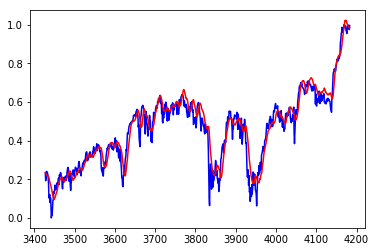

In [23]:

plt.plot(range(len(y_train), len(y_train)+len(y_test)), y_test, 'b-')
# plt.plot(range(len(y_pred_train)), y_pred_train, 'r-')
# plt.plot(range(len(y_train)), y_train, 'b-')
plt.plot(range(len(y_train),len(y_train)+len(y_pred)), y_pred, 'r-')
plt.show()

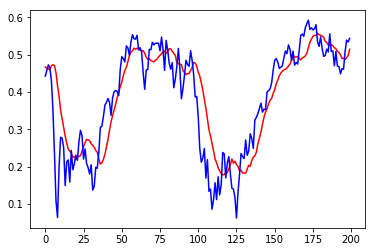

In [25]:
plt.plot(y_pred[400:600], 'r-')
plt.plot(y_test[400:600], 'b-')
plt.show()

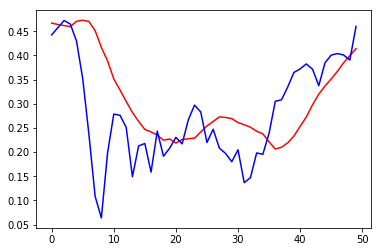

In [26]:
plt.plot(y_pred[400:450], 'r-')
plt.plot(y_test[400:450], 'b-')
plt.show()

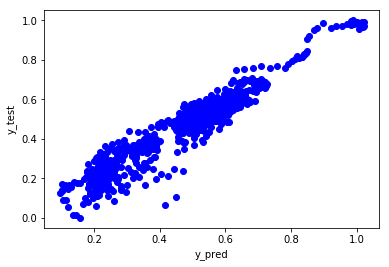

In [24]:
plt.plot (y_pred, y_test, 'bo')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()